In [1]:
%matplotlib inline

import sys
from glob import glob

import numpy as np
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
from matplotlib import lines, colors

from scipy.stats import norm
from scipy.stats.kde import gaussian_kde
from scipy.signal import savgol_filter

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

sys.path.append('/home/paul/Documents/multiviewtracks/MultiViewTracks/')
# download at https://github.com/pnuehrenberg/multiviewtracks

from utils import load, save, plot_tracks_2d
from tracks import tracks_to_pooled, tracks_from_pooled

from analysis import *

# Main analysis

In [2]:
trials = [('./predictions/tracks_T3_cleaned.pkl', 0, 1102, 25),
          ('./predictions/tracks_T4_cleaned.pkl', 8, 1095, 25),
          ('./predictions/tracks_T5_cleaned.pkl', 0, 1106, 25),
          ('./predictions/tracks_T6_cleaned.pkl', 7, 1109, 25),
          ('./predictions/tracks_T7_cleaned.pkl', 7, 1087, 25),
          ('./predictions/tracks_T12_cleaned.pkl', 9, 829, 60)]

bottom_length = 0.9652

In [3]:
dom_color = tuple(v / 255 for v in (255, 109, 69))
sub_color = tuple(v / 255 for v in (39, 170, 214))

all_data = []
angular_areas = load('visualfield/angular_areas_all.pkl')
all_time_above = []
all_event_ids = []
dom_idx = []
dom_all_event_times = []
dom_all_event_ids = []
dom_centrality = []
aa_out_dom = []
sub_all_event_times = []
sub_all_event_ids = []
sub_centrality = []
aa_out_sub = []

for trial_idx in range(len(trials)):
    tracks = load(trials[trial_idx][0])
    dom_id = trials[trial_idx][1]
    tracks, dom_id = enumerate_identities(tracks, dom_id)
    px_p_m = trials[trial_idx][2] / bottom_length
    fps = trials[trial_idx][3]
    dom_idx.append(dom_id) # np.argwhere(tracks['IDENTITIES'] == dom_id).ravel()[0]
    speed_distribution = get_speed_distribution(tracks, fps)
    q = np.quantile(speed_distribution, 0.95)
    intervals_above = threshold_speed(tracks, q, fps, dom_id=dom_id, plot=False)
    data = list(get_data(tracks, intervals_above, px_p_m))
    data[2] = angular_areas[trial_idx] # inject visual field reconstruction data here
    all_event_ids.append(data[-1])
    grouped_data = group_data(tracks, data, dom_id)
    all_data.append(grouped_data)
    dom_all_event_times.append(grouped_data[-2][0])
    sub_all_event_times.append(grouped_data[-2][1])
    dom_all_event_ids.append(grouped_data[-1][0])
    sub_all_event_ids.append(grouped_data[-1][1])

centrality_dom = np.concatenate([all_data[idx][0][0] for idx in range(len(all_data))])
centrality_sub = np.concatenate([all_data[idx][0][1] for idx in range(len(all_data))])
pairwise_dist_dom = np.concatenate([all_data[idx][1][0] for idx in range(len(all_data))])
pairwise_dist_sub = np.concatenate([all_data[idx][1][1] for idx in range(len(all_data))])
aa_out_dom = np.concatenate([all_data[idx][2][0] for idx in range(len(all_data))])
aa_out_sub = np.concatenate([all_data[idx][2][1] for idx in range(len(all_data))])
rel_time_above_dom = np.concatenate([all_data[idx][3][0] for idx in range(len(all_data))])
rel_time_above_sub = np.concatenate([all_data[idx][3][1] for idx in range(len(all_data))])

centrality = np.concatenate([np.array(centrality_sub).ravel(), np.array(centrality_dom).ravel()])
aa_out = np.concatenate([aa_out_sub, aa_out_dom])
pairwise_dist = np.concatenate([np.array(pairwise_dist_sub).ravel(), np.array(pairwise_dist_dom).ravel()])
event_frequency = np.concatenate([np.array(rel_time_above_sub).ravel(), np.array(rel_time_above_dom).ravel()])

social_parameters = pd.DataFrame.from_dict({'centrality': centrality,
                                            'aa_out': aa_out,
                                            'pairwise_dist': pairwise_dist,
                                            'noise_frequency': event_frequency,
                                            'social_status': ['SUB'] * 54 + ['DOM'] * 6,
                                            'trial': np.repeat(np.arange(6), 9).tolist() + np.arange(6).tolist()})

social_parameters.to_csv('social_parameters.csv')

scaler = preprocessing.StandardScaler()
for column in social_parameters.columns[:-2]:
    social_parameters[column] = scaler.fit_transform(np.array(social_parameters[column]).reshape(-1, 1)).ravel()
pca = PCA(n_components=len(social_parameters.columns[:-2]))
social_space = pca.fit_transform(np.array(social_parameters.iloc[:, :-2]))

delay_times = {'delay': np.concatenate([np.concatenate(np.concatenate([sub_times for sub_times in sub_all_event_times])),
                                        np.concatenate([dom_times for dom_times in dom_all_event_times])]),
               'id': np.concatenate([np.concatenate(np.concatenate([sub_ids for sub_ids in sub_all_event_ids])),
                                        np.concatenate([dom_ids for dom_ids in dom_all_event_ids])]),
               'social_status': ['SUB'] * np.concatenate(np.concatenate([sub_times for sub_times in sub_all_event_times])).size \
                                 + ['DOM'] * np.concatenate([dom_times for dom_times in dom_all_event_times]).size}

delay_times = pd.DataFrame.from_dict(delay_times)
delay_times.to_csv('delay_times.csv')

# Visualization

In [4]:
%matplotlib qt
mpl.rcParams['figure.dpi'] = 150

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 6))

bp = ax.boxplot([pairwise_dist_dom, pairwise_dist_sub],
                 widths=0.5, flierprops={'marker': 'o', 'markersize': 4},
                 medianprops={'color': 'k', 'linewidth': 2.5, 'linestyle': '--', 'dashes': (1, 0), 'alpha': 0.75},
                 patch_artist=True)
bp['boxes'][0].set(facecolor=dom_color)
bp['boxes'][1].set(facecolor=sub_color)

plt.xticks([1, 1, 2, 2])
ax.set_xticklabels([r'$Dom$', '\n''({})'.format(len(pairwise_dist_dom)),
                    r'$Sub$', '\n''({})'.format(len(pairwise_dist_sub))], fontsize=14)
for label in ax.get_xmajorticklabels():
    if '(' in label.get_text():
        label.set_size(12)
        label.set_linespacing(1.75)

ax.set_ylabel('mean pairwise distance (m)', fontsize=14)

lines_list = []

y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
bracket_height = 0.025
bracket_y = ax.get_ylim()[1] + 2 * y_range * bracket_height

for x_values, idx in zip([[1, 1.35], [1.65, 2]], [0, 1]):
    line = lines.Line2D(x_values, [bracket_y, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)
    line = lines.Line2D([x_values[idx]] * 1, [bracket_y - y_range * bracket_height, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)

for line in lines_list:
    ax.add_line(line)

ax.text(1.5, bracket_y, '*', horizontalalignment='center', verticalalignment='center', size=12, color='k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 6))

bp = ax.boxplot([rel_time_above_dom, rel_time_above_sub],
                 widths=0.5, flierprops={'marker': 'o', 'markersize': 4},
                 medianprops={'color': 'k', 'linewidth': 2.5, 'linestyle': '--', 'dashes': (1, 0), 'alpha': 0.75},
                 patch_artist=True)
bp['boxes'][0].set(facecolor=dom_color)
bp['boxes'][1].set(facecolor=sub_color)

plt.xticks([1, 1, 2, 2])
ax.set_xticklabels([r'$Dom$', '\n''({})'.format(len(rel_time_above_dom)),
                    r'$Sub$', '\n''({})'.format(len(rel_time_above_sub))], fontsize=14)
for label in ax.get_xmajorticklabels():
    if '(' in label.get_text():
        label.set_size(12)
        label.set_linespacing(1.75)

ax.set_ylabel('noise frequency', fontsize=14)

lines_list = []

y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
bracket_height = 0.025
bracket_y = ax.get_ylim()[1] + 2 * y_range * bracket_height

for x_values, idx in zip([[1, 1.35], [1.65, 2]], [0, 1]):
    line = lines.Line2D(x_values, [bracket_y, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)
    line = lines.Line2D([x_values[idx]] * 2, [bracket_y - y_range * bracket_height, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)

for line in lines_list:
    ax.add_line(line)

ax.text(1.5, bracket_y, '*', horizontalalignment='center', verticalalignment='center', size=12, color='k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()

plt.show()

In [5]:
plt.rcParams['lines.scale_dashes'] = False

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, label=0)
ax_loadings= fig.add_subplot(111, label=1, frame_on=False)

ax.scatter(social_space[social_parameters['social_status'] == 'DOM', 0],
           social_space[social_parameters['social_status'] == 'DOM', 1],
           c=np.array(dom_color).reshape(1, -1), edgecolor='k', label=r'$Dom$')
ax.scatter(social_space[social_parameters['social_status'] == 'SUB', 0],
           social_space[social_parameters['social_status'] == 'SUB', 1],
           c=np.array(sub_color).reshape(1, -1), edgecolor='k', label=r'$Sub$')
ax.set_xlabel(r'PC1 ({:.1f}% $EV$)'.format(pca.explained_variance_ratio_[0] * 100), fontsize=14)
ax.set_ylabel(r'PC2 ({:.1f}% $EV$)'.format(pca.explained_variance_ratio_[1] * 100), fontsize=14)

scale = 1.7
loadings = pca.components_.T * np.sqrt(pca.explained_variance_) * scale
for loading, label in zip(loadings, ['network centrality', 'mean angular area', 'mean pairwise distance', 'noise frequency']):
    ax_loadings.plot([0, loading[0]], [0, loading[1]], 'k--', solid_capstyle='round', lw=1)
    ax_loadings.text(loading[0] + 0.1, loading[1] + (0.1 if label == 'network centrality' else -0.2), label, fontsize=12)
ax_loadings.scatter(loadings[:, 0], loadings[:, 1], marker='+', c='k', s=50, lw=1)
ax_loadings.set_xlabel(r'loading on PC1', fontsize=14)
ax_loadings.set_ylabel(r'loading on PC2', fontsize=14)

ax.legend(edgecolor='k', fancybox=True, borderaxespad=0, bbox_to_anchor=(0.95, 0.95), loc='upper right', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax_loadings.spines['left'].set_visible(False)
ax_loadings.spines['bottom'].set_visible(False)
ax_loadings.yaxis.set_ticks_position('right')
ax_loadings.xaxis.set_ticks_position('top')
ax_loadings.set_yticks([-scale, 0, scale])
ax_loadings.set_xticks([-scale, 0, scale])
ax_loadings.set_yticklabels([-1, 0, 1])
ax_loadings.set_xticklabels([-1, 0, 1])
ax_loadings.xaxis.set_label_position('top')
ax_loadings.yaxis.set_label_position('right')

ax.set_aspect('equal')
ax_loadings.set_aspect('equal')
ax_loadings.set_ylim(ax.get_ylim())
ax_loadings.set_xlim(ax.get_xlim())
ax_loadings.plot([ax.get_xlim()[1]] * 2, [-scale, scale], 'k--', lw=2)
ax_loadings.plot([-scale, scale], [ax.get_ylim()[1]] * 2, 'k--', lw=2)
ax_loadings.xaxis.set_label_coords(0.33, 1.075)
ax_loadings.yaxis.set_label_coords(1.04, 0.475)


fig.tight_layout()

plt.show()

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [0.4, 0.5], 'wspace': 0.3})

axes[0].bar(np.arange(4), pca.explained_variance_ratio_ * 100, facecolor=(0, 0, 0, 0.1), edgecolor=(0, 0, 0, 0.4))
axes[0].plot(pca.explained_variance_ratio_ * 100, 'ko-')

for x, ev in enumerate(pca.explained_variance_ratio_ * 100):
    axes[0].text(x, ev + 2, '{:.1f}%'.format(ev), fontsize=12)
    
axes[0].set_ylabel('explained variance (%)', fontsize=14)
axes[0].set_xticks(np.arange(4))
axes[0].set_xticklabels(np.arange(4) + 1)
axes[0].set_xlabel('principal component', fontsize=14)

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')

silhouette_avg = []

for n_clusters in np.arange(2, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(social_space)

    silhouette_avg.append(silhouette_score(social_space, cluster_labels))

axes[1].plot(np.arange(2, 11), silhouette_avg, 'ko-')
axes[1].set_xlabel('number of clusters', fontsize=14)
axes[1].set_ylabel('mean silhouette coefficient', fontsize=14)

axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')
    
# fig.tight_layout()

plt.show()

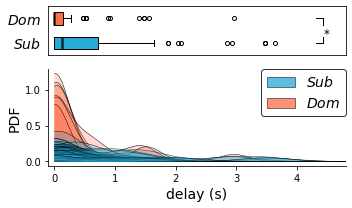

In [7]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5, 3), gridspec_kw={'height_ratios': [0.3, 0.6]})
ax_dist, ax = axes

x_d = np.linspace(0, 120, 10000)
y_values = []
color_values = []

for idx, (trial_dom_times, trial_sub_times) in enumerate(zip(dom_all_event_times, sub_all_event_times)):
    
    for sub_times in trial_sub_times:
        x = sub_times
        if len(x) == 0:
            continue
        density = sum(norm(xi, scale=10).pdf(x_d) for xi in x)
        area = (density * np.diff(x_d)[0]).sum()
        y_values.append(density / area * len(x))
        color_values.append(np.array(sub_color))

    x = trial_dom_times
    if len(x) == 0:
        continue
    density = sum(norm(xi, scale=6).pdf(x_d) for xi in x)
    area = (density * np.diff(x_d)[0]).sum()
    y_values.append(density / area * len(x))
    color_values.append(np.array(dom_color))

y_values = np.array(y_values)
sort_idx = np.argsort(y_values.max(axis=1))[::-1]
y_values = y_values[sort_idx]
color_values = np.array(color_values)[sort_idx]

ax.fill_between([], [], facecolor=(*sub_color, 0.75), edgecolor=(0, 0, 0, 1), lw=0.5, label=r'$Sub$')
ax.fill_between([], [], facecolor=(*dom_color, 0.75), edgecolor=(0, 0, 0, 1), lw=0.5, label=r'$Dom$')

for idx, (y, c) in enumerate(zip(y_values, color_values)):
    ax.fill_between(x_d, y, alpha=0.25, facecolor=c, zorder=idx)
    ax.plot(x_d, y, alpha=1 - (idx + 1) / 80, lw=0.5, c='k', zorder=idx, solid_capstyle='butt')

ax.legend(edgecolor='k', fancybox=True, borderaxespad=0, fontsize=14, bbox_to_anchor=(1, 1), loc='upper right')

bp = ax_dist.boxplot([np.concatenate(np.concatenate([sub_times for sub_times in sub_all_event_times])),
                      np.concatenate([dom_times for dom_times in dom_all_event_times])],
                     vert=False, widths=0.5, flierprops={'marker': 'o', 'markersize': 4},
                     medianprops={'color': 'k', 'linewidth': 2.5, 'linestyle': '--', 'dashes': (1, 0), 'alpha': 0.75},
                     patch_artist=True)
bp['boxes'][0].set(facecolor=sub_color)
bp['boxes'][1].set(facecolor=dom_color)

ax.set_xlim(-2.5, 120)
ax.set_xticks(np.arange(0, 125, 25))
ax.set_xticklabels(np.arange(0, 5))
ax.set_xlabel('delay (s)', fontsize=14)
ax.set_ylabel('PDF', fontsize=14) # count

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax_dist.tick_params(axis='y', width=0, labelsize=14)
ax_dist.get_xaxis().set_visible(False)
ax_dist.set_yticks([1, 2])
ax_dist.set_yticklabels([r'$Sub$', r'$Dom$'])

lines_list = []

x_range = ax_dist.get_xlim()[1] - ax.get_xlim()[0]
bracket_width = 0.025
bracket_x = ax.get_xlim()[1] - 3 * x_range * bracket_width

for y_values, idx in zip([[1, 1.25], [1.75, 2]], [0, 1]):
    line = lines.Line2D([bracket_x, bracket_x], y_values, lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)
    line = lines.Line2D([bracket_x - x_range * bracket_width, bracket_x], [y_values[idx]] * 2, lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)

for line in lines_list:
    ax_dist.add_line(line)

ax_dist.text(bracket_x + 1.2, 1.375, '*', horizontalalignment='center', verticalalignment='center', size=12, color='k')

plt.tight_layout()

plt.show()

In [ ]:
# fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5, 3), gridspec_kw={'height_ratios': [0.3, 0.6]})
# ax_dist, ax = axes

fig, ax = plt.subplots(figsize=(5, 3))

x_d = np.linspace(0, 120, 10000)
y_values = []
color_values = []

trial_dom_times = np.concatenate([dom_times for dom_times in dom_all_event_times])
sub_times = np.concatenate(np.concatenate([sub_times for sub_times in sub_all_event_times]))
    
density = gaussian_kde(sub_times)(x_d)
y_values.append(density)
color_values.append(np.array(sub_color))

density = gaussian_kde(trial_dom_times)(x_d)
y_values.append(density)
color_values.append(np.array(dom_color))

y_values = np.array(y_values)
sort_idx = np.argsort(y_values.max(axis=1))[::-1]
y_values = y_values[sort_idx]
color_values = np.array(color_values)[sort_idx]

ax.fill_between([], [], facecolor=(*sub_color, 0.75), edgecolor=(0, 0, 0, 1), lw=0.5, label=r'$Sub$')
ax.fill_between([], [], facecolor=(*dom_color, 0.75), edgecolor=(0, 0, 0, 1), lw=0.5, label=r'$Dom$')

for idx, (y, c) in enumerate(zip(y_values, color_values)):
    ax.fill_between(x_d, y, alpha=0.6, facecolor=c, zorder=idx)
    ax.plot(x_d, y, alpha=1, lw=0.5, c='k', zorder=idx, solid_capstyle='butt')

ax.legend(edgecolor='k', fancybox=True, borderaxespad=0, fontsize=14, bbox_to_anchor=(1, 1), loc='upper right')

# bp = ax_dist.boxplot([np.concatenate(np.concatenate([sub_times for sub_times in sub_all_event_times])),
#                       np.concatenate([dom_times for dom_times in dom_all_event_times])],
#                      vert=False, widths=0.5, flierprops={'marker': 'o', 'markersize': 4},
#                      medianprops={'color': 'k', 'linewidth': 2.5, 'linestyle': '--', 'dashes': (1, 0), 'alpha': 0.75},
#                      patch_artist=True)
# bp['boxes'][0].set(facecolor=sub_color)
# bp['boxes'][1].set(facecolor=dom_color)

ax.set_xlim(-2.5, 120)
ax.set_xticks(np.arange(0, 125, 25))
ax.set_xticklabels(np.arange(0, 5))
ax.set_xlabel('delay (s)', fontsize=14)
ax.set_ylabel('probability density', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# ax_dist.tick_params(axis='y', width=0, labelsize=14)
# ax_dist.get_xaxis().set_visible(False)
# ax_dist.set_yticks([1, 2])
# ax_dist.set_yticklabels([r'$Sub$', r'$Dom$'])

# lines_list = []

# x_range = ax_dist.get_xlim()[1] - ax.get_xlim()[0]
# bracket_width = 0.025
# bracket_x = ax.get_xlim()[1] - 3 * x_range * bracket_width

# for y_values, idx in zip([[1, 1.25], [1.75, 2]], [0, 1]):
#     line = lines.Line2D([bracket_x, bracket_x], y_values, lw=1, color='k')
#     line.set_clip_on(False)
#     lines_list.append(line)
#     line = lines.Line2D([bracket_x - x_range * bracket_width, bracket_x], [y_values[idx]] * 2, lw=1, color='k')
#     line.set_clip_on(False)
#     lines_list.append(line)

# for line in lines_list:
#     ax_dist.add_line(line)

# ax_dist.text(bracket_x + 1.2, 1.375, '*', horizontalalignment='center', verticalalignment='center', size=12, color='k')

plt.tight_layout()

plt.show()

In [ ]:
# mpl.rcParams['figure.dpi'] = 100

trial_idx = 4

tracks = load(trials[trial_idx][0])
event_ids = all_event_ids[trial_idx]
dom_id = trials[trial_idx][1]

# rerun until good network layout
centrality = get_social_influence(tracks, event_ids, dom_id, plot=False, plot_network=True)

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 6))

bp = plt.boxplot([centrality_dom, centrality_sub],
                  widths=0.5, flierprops={'marker': 'o', 'markersize': 4},
                  medianprops={'color': 'k', 'linewidth': 2.5, 'linestyle': '--', 'dashes': (1, 0), 'alpha': 0.75},
                  patch_artist=True)
bp['boxes'][0].set(facecolor=dom_color)
bp['boxes'][1].set(facecolor=sub_color)

ax.set_ylim((0.15, 0.6))
ax.set_yticks(np.arange(0.2, 0.6, 0.1))
ax.set_ylabel('network centrality', fontsize=14)

plt.xticks([1, 1, 2, 2])
ax.set_xticklabels([r'$Dom$', '\n''({})'.format(len(centrality_dom)),
                    r'$Sub$', '\n''({})'.format(len(centrality_sub))], fontsize=14)
for label in ax.get_xmajorticklabels():
    if '(' in label.get_text():
        label.set_size(12)
        label.set_linespacing(1.75)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

lines_list = []

y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
bracket_height = 0.025
bracket_y = ax.get_ylim()[1] - 1 * y_range * bracket_height

for x_values, idx in zip([[1, 1.35], [1.65, 2]], [0, 1]):
    line = lines.Line2D(x_values, [bracket_y, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)
    line = lines.Line2D([x_values[idx]] * 2, [bracket_y - y_range * bracket_height, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)

for line in lines_list:
    ax.add_line(line)

ax.text(1.5, bracket_y, '*', horizontalalignment='center', verticalalignment='center', size=12, color='k')

fig.tight_layout()

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 6))

bp = ax.boxplot([aa_out_dom, aa_out_sub],
                 widths=0.5, flierprops={'marker': 'o', 'markersize': 4},
                 medianprops={'color': 'k', 'linewidth': 2.5, 'linestyle': '--', 'dashes': (1, 0), 'alpha': 0.75},
                 patch_artist=True)
bp['boxes'][0].set(facecolor=dom_color)
bp['boxes'][1].set(facecolor=sub_color)

plt.xticks([1, 1, 2, 2])
ax.set_xticklabels([r'$Dom$', '\n''({})'.format(len(aa_out_dom)),
                    r'$Sub$', '\n''({})'.format(len(aa_out_sub))], fontsize=14)
for label in ax.get_xmajorticklabels():
    if '(' in label.get_text():
        label.set_size(12)
        label.set_linespacing(1.75)

ax.set_ylabel('mean angular area (°)', fontsize=14)

lines_list = []

y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
bracket_height = 0.025
bracket_y = ax.get_ylim()[1] + 2 * y_range * bracket_height

for x_values, idx in zip([[1, 1.25], [1.75, 2]], [0, 1]):
    line = lines.Line2D(x_values, [bracket_y, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)
    line = lines.Line2D([x_values[idx]] * 1, [bracket_y - y_range * bracket_height, bracket_y], lw=1, color='k')
    line.set_clip_on(False)
    lines_list.append(line)

for line in lines_list:
    ax.add_line(line)

ax.text(1.5, bracket_y, 'ns', horizontalalignment='center', verticalalignment='center', size=12, color='k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()

plt.show()

In [ ]:
trial_idx = 2

tracks = load(trials[trial_idx][0])
dom_id = trials[trial_idx][1]
px_p_m = trials[trial_idx][2] / bottom_length
fps = trials[trial_idx][3]

speed_distribution = get_speed_distribution(tracks, fps)
q = np.quantile(speed_distribution, 0.95)
_ = threshold_speed(tracks, q=q, fps=fps, dom_id=dom_id,
                    plot=True,
                    xlim=(2*25*60, 3.3*25*60),
                    figsize=(8.5, 3.2),
                    xticks=np.arange(2*25*60, 3.3*25*60 + 250, 25*10),
                    xticklabels=np.arange(0, 100, 10),
                    ylabel=r'speed (m * s$^{-1}$)',
                    xlabel='time (s)',
                    q_label=r'$v_{95\%}$',
                    scale=px_p_m,
                    legend_bbox_to_anchor=(0.01, 1))

In [ ]:
for tracks_file in glob('/home/paul/Documents/BurtoniLearningExp/predictions/*cleaned.pkl'):
    tracks = load(tracks_file)
    for i in tracks['IDENTITIES']:
        tracks[str(i)]['X'] = tracks[str(i)]['SPINE'][:, 1, 1]
        tracks[str(i)]['Y'] = tracks[str(i)]['SPINE'][:, 1, 0]
        for key in [key for key in tracks[str(i)]]:
            if key not in ['FRAME_IDX', 'X', 'Y']:
                tracks[str(i)].pop(key)
    pooled = tracks_to_pooled(tracks)
    pd.DataFrame(pooled).to_csv(tracks_file.replace('_cleaned.pkl', '.csv'))

# Network randomization

In [5]:
def plot_network_randomization(avg_metric_sub, avg_metric_dom, metric_sub, metric_dom, min_x_sub, max_x_sub, min_x_dom, max_x_dom, ylabel, xlim_hist, alpha_level=0.05):

    y_values_sub = []
    mean_values_sub = []
    x_d_sub = np.linspace(min_x_sub, max_x_sub, 1000)

    for dist in np.concatenate([trial for trial in np.array(avg_metric_sub).reshape(6, 1000, -1)], axis=1):
        dist = dist[np.isfinite(dist)]
#         try:
#             y_values_sub.append(gaussian_kde(dist)(x_d_sub))
#         except:
#             pass
        mean_values_sub.append(dist.mean())

    y_values_dom = []
    mean_values_dom = []
    x_d_dom = np.linspace(min_x_dom, max_x_dom, 1000)

    for dist in np.concatenate([trial for trial in np.array(avg_metric_dom).reshape(6, 1000, -1)], axis=1):
        dist = dist[np.isfinite(dist)]
#         try:
#             y_values_dom.append(gaussian_kde(dist)(x_d_dom))
#         except:
#             pass
        mean_values_dom.append(dist.mean())

    mean_values_dom = np.array(mean_values_dom)
    mean_values_sub = np.array(mean_values_sub)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [0.5, 0.4]})

#     kde_dom = gaussian_kde(metric_dom)
#     kde_sub = gaussian_kde(metric_sub)

#     axes[0].fill_betweenx(x_d_dom, -np.array(y_values_dom).mean(axis=0) / kde_dom(x_d_dom).max(),
#                           alpha=0.5, facecolor='k', zorder=0)
#     axes[0].plot(-np.array(y_values_dom).mean(axis=0) / kde_dom(x_d_dom).max(), x_d_dom,
#                  alpha=1, lw=0.5, c='k', zorder=1, solid_capstyle='butt')
#     axes[0].fill_betweenx(x_d_sub, 5 + np.array(y_values_sub).mean(axis=0) / kde_sub(x_d_sub).max(), 5,
#                           alpha=0.5, facecolor='k', zorder=0)
#     axes[0].plot(5 + np.array(y_values_sub).mean(axis=0) / kde_sub(x_d_sub).max(), x_d_sub,
#                  alpha=1, lw=0.5, c='k', zorder=1, solid_capstyle='butt')

#     axes[0].plot(-kde_dom(x_d_dom) / kde_dom(x_d_dom).max(), x_d_dom, color=dom_color, zorder=2)
#     axes[0].plot(5 + kde_sub(x_d_sub) / kde_sub(x_d_sub).max(), x_d_sub, color=sub_color, zorder=2)

    lc = LineCollection(np.transpose([np.repeat(1, mean_values_dom.size),
                                      mean_values_dom,
                                      np.repeat(4, mean_values_sub.size),
                                      mean_values_sub]).reshape(-1, 2, 2),
                        lw=0.5,
                        alpha=0.1,
                        color=(0.2, 0.2, 0.2), zorder=0,
                        capstyle='butt')
    axes[0].add_collection(lc)

    axes[0].scatter(np.random.uniform(0.1, 0.9, mean_values_dom.size),
                    mean_values_dom,
                    s=5,
                    facecolor=(0.5, 0.5, 0.5),
                    edgecolor='k',
                    lw=0.4)
    axes[0].scatter(np.random.uniform(4.1, 4.9, mean_values_sub.size),
                    mean_values_sub,
                    s=5,
                    facecolor=(0.5, 0.5, 0.5),
                    edgecolor='k',
                    lw=0.4)

    axes[0].plot([1, 4], [metric_dom.mean(), metric_sub.mean()], '--', color='k', solid_capstyle='butt')
    axes[0].scatter([0.5, 4.5], [metric_dom.mean(), metric_sub.mean()], s=20,
                    marker='o', facecolor=np.array([dom_color, sub_color]), edgecolor='k')

    axes[0].set_ylabel(ylabel, fontsize=14)
    axes[0].set_xticks([0.5, 4.5])
    axes[0].set_xticklabels([r'$Dom$', r'$Sub$'], fontsize=14)

    differences = mean_values_dom - mean_values_sub
    pdf = gaussian_kde(differences)
    padding = (differences.max() - differences.min())
    x = np.linspace(differences.min() - padding , differences.max() + padding, 1000)
    
    cdf = np.cumsum(pdf(x)) * np.diff(x)[0]
    left = np.argwhere(cdf <= alpha_level / 2).ravel().max()
    right = np.argwhere(cdf >= 1 - alpha_level / 2).ravel().min()
    observed = metric_dom.mean() - metric_sub.mean()
    idx = np.argmin(np.abs(x - observed))
    if np.abs(observed - x[left]) <= np.abs(observed - x[right]):
        p_value = 2 * cdf[idx + 1]
    else:
        p_value = 2 * (1 - cdf[idx])

    axes[1].hist(mean_values_dom - mean_values_sub, bins=30, density=True,
                 facecolor=(0, 0, 0, 0.1), edgecolor=(0, 0, 0, 0.4))
    axes[1].fill_between(x[:left + 1], pdf(x[:left + 1]), facecolor='#7CB939', alpha=0.75)
    axes[1].fill_between(x[left:right + 1], pdf(x[left:right + 1]), facecolor='k', alpha=0.25)
    axes[1].fill_between(x[right:], pdf(x[right:]), facecolor='#7CB939', alpha=0.75)
    axes[1].plot([x[left]] * 2, [0, pdf(x[left])], c='k', alpha=0.75, lw=0.5, solid_capstyle='butt')
    axes[1].plot([x[right]] * 2, [0, pdf(x[right])], c='k', alpha=0.75, lw=0.5, solid_capstyle='butt')
    axes[1].plot(x, pdf(x), alpha=1, lw=0.5, c='k', solid_capstyle='butt')

    axes[1].axvline(observed, linestyle='--', color='k', solid_capstyle='butt', ymax=0.9)
    axes[1].set_xlim(xlim_hist)
    axes[1].set_xlabel('mean difference', fontsize=14)
    axes[1].set_ylabel('density', fontsize=14)

    for ax in axes.ravel():
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

    fig.tight_layout()
    plt.show()
    
    print('p-value: {}'.format(p_value))

In [14]:
dom_color = tuple(v / 255 for v in (255, 109, 69))
sub_color = tuple(v / 255 for v in (39, 170, 214))

angular_areas = load('visualfield/angular_areas_all.pkl')
avg_centrality_dom = []
avg_centrality_sub = []
avg_pairwise_dist_dom = []
avg_pairwise_dist_sub = []
avg_aa_out_dom = []
avg_aa_out_sub = []
avg_rel_time_above_dom = []
avg_rel_time_above_sub = []
avg_initiator_count_dom = []
avg_initiator_count_sub = []

for trial_idx in range(len(trials)):

    tracks = load(trials[trial_idx][0])
    dom_id = trials[trial_idx][1]
    tracks, dom_id = enumerate_identities(tracks, dom_id)
    px_p_m = trials[trial_idx][2] / bottom_length
    fps = trials[trial_idx][3]
            
    speed_distribution = get_speed_distribution(tracks, fps)
    q = np.quantile(speed_distribution, 0.95)
    intervals_above = threshold_speed(tracks, q, fps, dom_id=dom_id, plot=False)
    
    data = list(get_data(tracks, intervals_above, px_p_m))
    data[2] = angular_areas[trial_idx] # inject visual field data here
    
    for _ in range(1000):
        grouped_data = group_data(tracks, data, np.random.randint(10))

        avg_centrality_dom.append(grouped_data[0][0])
        avg_centrality_sub.append(grouped_data[0][1])
        avg_pairwise_dist_dom.append(grouped_data[1][0])
        avg_pairwise_dist_sub.append(grouped_data[1][1])
        avg_aa_out_dom.append(grouped_data[2][0])
        avg_aa_out_sub.append(grouped_data[2][1])
        avg_rel_time_above_dom.append(grouped_data[3][0])
        avg_rel_time_above_sub.append(grouped_data[3][1])
        avg_initiator_count_dom.append(np.array([(grouped_data[-2][0] == 0).sum()]))
        avg_initiator_count_sub.append(np.array([(grouped_data[-2][1][idx] == 0).sum() \
                                                 for idx in range(9)]))

In [21]:
mpl.rcParams['figure.dpi'] = 150

In [22]:
%matplotlib qt

In [23]:
plot_network_randomization(avg_metric_sub=avg_centrality_sub,
                           avg_metric_dom=avg_centrality_dom,
                           metric_sub=centrality_sub,
                           metric_dom=centrality_dom,
                           min_x_sub=0.15,
                           max_x_sub=0.6,
                           min_x_dom=0.15,
                           max_x_dom=0.6,
                           ylabel='network centrality',
                           xlim_hist=(-0.1, 0.2))

p-value: 1.1546319456101628e-14


In [24]:
initiator_count_dom = np.array([(event_times == 0).sum() for event_times in dom_all_event_times])
initiator_count_sub = np.array([(event_times == 0).sum() if event_times.size > 0 else 0 for event_times in np.concatenate(sub_all_event_times)])

plot_network_randomization(avg_metric_sub=avg_initiator_count_sub,
                           avg_metric_dom=avg_initiator_count_dom,
                           metric_sub=initiator_count_sub,
                           metric_dom=initiator_count_dom,
                           min_x_sub=0.0,
                           max_x_sub=10.0,
                           min_x_dom=0.0,
                           max_x_dom=10.0,
                           ylabel='initiator count',
                           xlim_hist=(-3, 7))

p-value: 1.0436096431476471e-14


In [25]:
plot_network_randomization(avg_metric_sub=avg_pairwise_dist_sub,
                           avg_metric_dom=avg_pairwise_dist_dom,
                           metric_sub=pairwise_dist_sub,
                           metric_dom=pairwise_dist_dom,
                           min_x_sub=0.05,
                           max_x_sub=0.55,
                           min_x_dom=0.05,
                           max_x_dom=0.55,
                           ylabel='mean pairwise distance (m)',
                           xlim_hist=(-0.05, 0.1))

p-value: 2.0395205524437188e-09


In [26]:
plot_network_randomization(avg_metric_sub=avg_aa_out_sub,
                           avg_metric_dom=avg_aa_out_dom,
                           metric_sub=aa_out_sub,
                           metric_dom=aa_out_dom,
                           min_x_sub=2,
                           max_x_sub=16,
                           min_x_dom=2,
                           max_x_dom=16,
                           ylabel='mean angular area (°)',
                           xlim_hist=(-3.5, 3.5))

p-value: 0.20687280739376496


In [ ]:
coverage_cleaned = []
coverage_initial = []
identified = []

for trial_idx in range(len(trials)):
    tracks = load(trials[trial_idx][0])
    pooled = tracks_to_pooled(tracks)
    coverage_cleaned.append(pooled['FRAME_IDX'].size / (pooled['FRAME_IDX'].max() * 10))
    tracks = load(trials[trial_idx][0].replace('_cleaned', ''))
    pooled = tracks_to_pooled(tracks)
    coverage_initial.append(pooled['FRAME_IDX'].size / (pooled['FRAME_IDX'].max() * 10))
    identified.append(tracks['IDENTITIES'].size)
    print(pooled['FRAME_IDX'].max() / (60 * trials[trial_idx][-1]))
    
print('initial coverage:', np.mean(coverage_initial))
print('average losses:', np.mean(identified) / 10)
print('false predictions:', 1 - np.mean(coverage_cleaned) / np.mean(coverage_initial))
print('processed coverage:', np.mean(coverage_cleaned))

import numpy as np
import h5py

with h5py.File('/home/paul/Documents/BurtoniLearningExp/mask_rcnn/dataset.h5', 'r') as annotations:
    annotated = annotations['annotations'][:]
print(np.array(annotated).astype(np.str))
print('number of annotations:', len(annotated))